<a href="https://colab.research.google.com/github/DoubleCyclone/house-price-prediction/blob/main/notebooks/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will be working with the "**House Prices - Advanced Regression Techniques**" dataset today to perform
*   Exploratory Data Analysis
*   Data Preprocessing
*   Feature Engineering
*   Model Building
*   Evaluation
*   and Visualisation

First things first, I am going to mount google drive so that I can upload the dataset there and easily access it from the notebook.

The dataset (and the competition) is at [Kaggle Competition/Dataset Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

In [552]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [553]:
# Let's import the other dependencies as well
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# 1 - Exploratory Data Analysis
I will start by reading the train.csv which is the training dataset and displaying a small portion of it.

In [554]:
# Load the training and test datasets, examine their shapes and contents
data_train = pd.read_csv('/content/drive/MyDrive/Colab_Materials/House_Price_Estimation/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab_Materials/House_Price_Estimation/test.csv')
# I will drop the ID columns as they are not used for training models
data_train = data_train.drop('Id', axis=1)
data_test = data_test.drop('Id', axis=1)

print(f"Shape of the train dataset = {data_train.shape}")
data_train.head()

Shape of the train dataset = (1460, 80)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [555]:
print(f"Shape of the test dataset = {data_test.shape}")
data_test.head()

Shape of the test dataset = (1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          20       RH         80.0    11622   Pave   NaN      Reg   
1          20       RL         81.0    14267   Pave   NaN      IR1   
2          60       RL         74.0    13830   Pave   NaN      IR1   
3          60       RL         78.0     9978   Pave   NaN      IR1   
4         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
3         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
4         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       6    2010        WD         Normal  
1        Gar2   12500       6    2010        WD         Normal  
2         NaN       0       3    2010        WD         Normal  
3         NaN       0       6    2010        WD         Normal  
4         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

Seems like there are almost an equal amount of data in both datasets. There is also one more column in the train dataset called **SalePrice** is the sale price which will be the labels the model will learn from in this case. How about getting an idea of its distribution in the dataset?

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


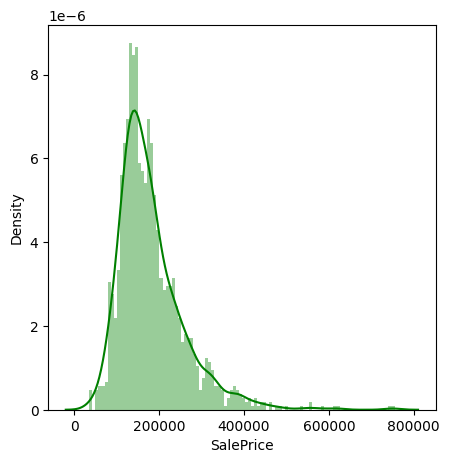

In [556]:
# Use the pandas.describe method to automatically generate valuable information about the dataset (only for a numerical variable in this case)
print(data_train['SalePrice'].describe())

# Plot the distribution of the SalePrice column
plt.figure(figsize=(5, 5))
sns.distplot(data_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

# Move the SalePrice (label)
data_y = data_train['SalePrice']

# Drop label from the DataFrame
data_train.drop('SalePrice', axis=1, inplace=True)

By looking at the output of the pandas.describe function and the graph, we can see that most of the Sale Prices reside at around 180000 and the standard deviation is quite low. Meaning that the data has low variability. How do I decide if the standard deviation is low or not? Firstly, I calculate the range of the data which is **max - min**. In this case **755000 - 34900 = 720100**. If the standard deviation is close to the range, I can say that the variability is high but in our case, standard deviation is approximately 10x lesser than the range which lets us conclude that the standard deviation, thus the variability in Sale Prices is low. <br><br>
Now let's see what type of data is stored in the training dataset.

In [557]:
# Print the list of unique data types
list(set(data_train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

Now let's store the numerical data in a new DataFrame so that we can use it easily.

In [558]:
# Create a new DataFrame for numerical data only
train_num = data_train.select_dtypes(include = ['float64', 'int64'])
train_num.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
0          2003       196.0         706           0  ...         548   
1          1976         0.0         978           0  ...         460   
2          2002       162.0         486           0  ...         608   
3          1970         0.0         216           0  ...         642   
4          2000       350.0         655           0  ...         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           61              0          0            0         0   
1         298            0              0          0            0         0   
2           0           42              0          0            0         0   
3           0           35            272          0            0         0   
4         192           84              0          0            0         0   

   MiscVal  MoSold  YrSold  
0        0       2    2008  
1        0       5    2007  
2        0       9    2008  
3        0       2    2006  
4        0      12    2008  

[5 rows x 36 columns]

While at that, let's plot the distributions of all these numerical features at the same time.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

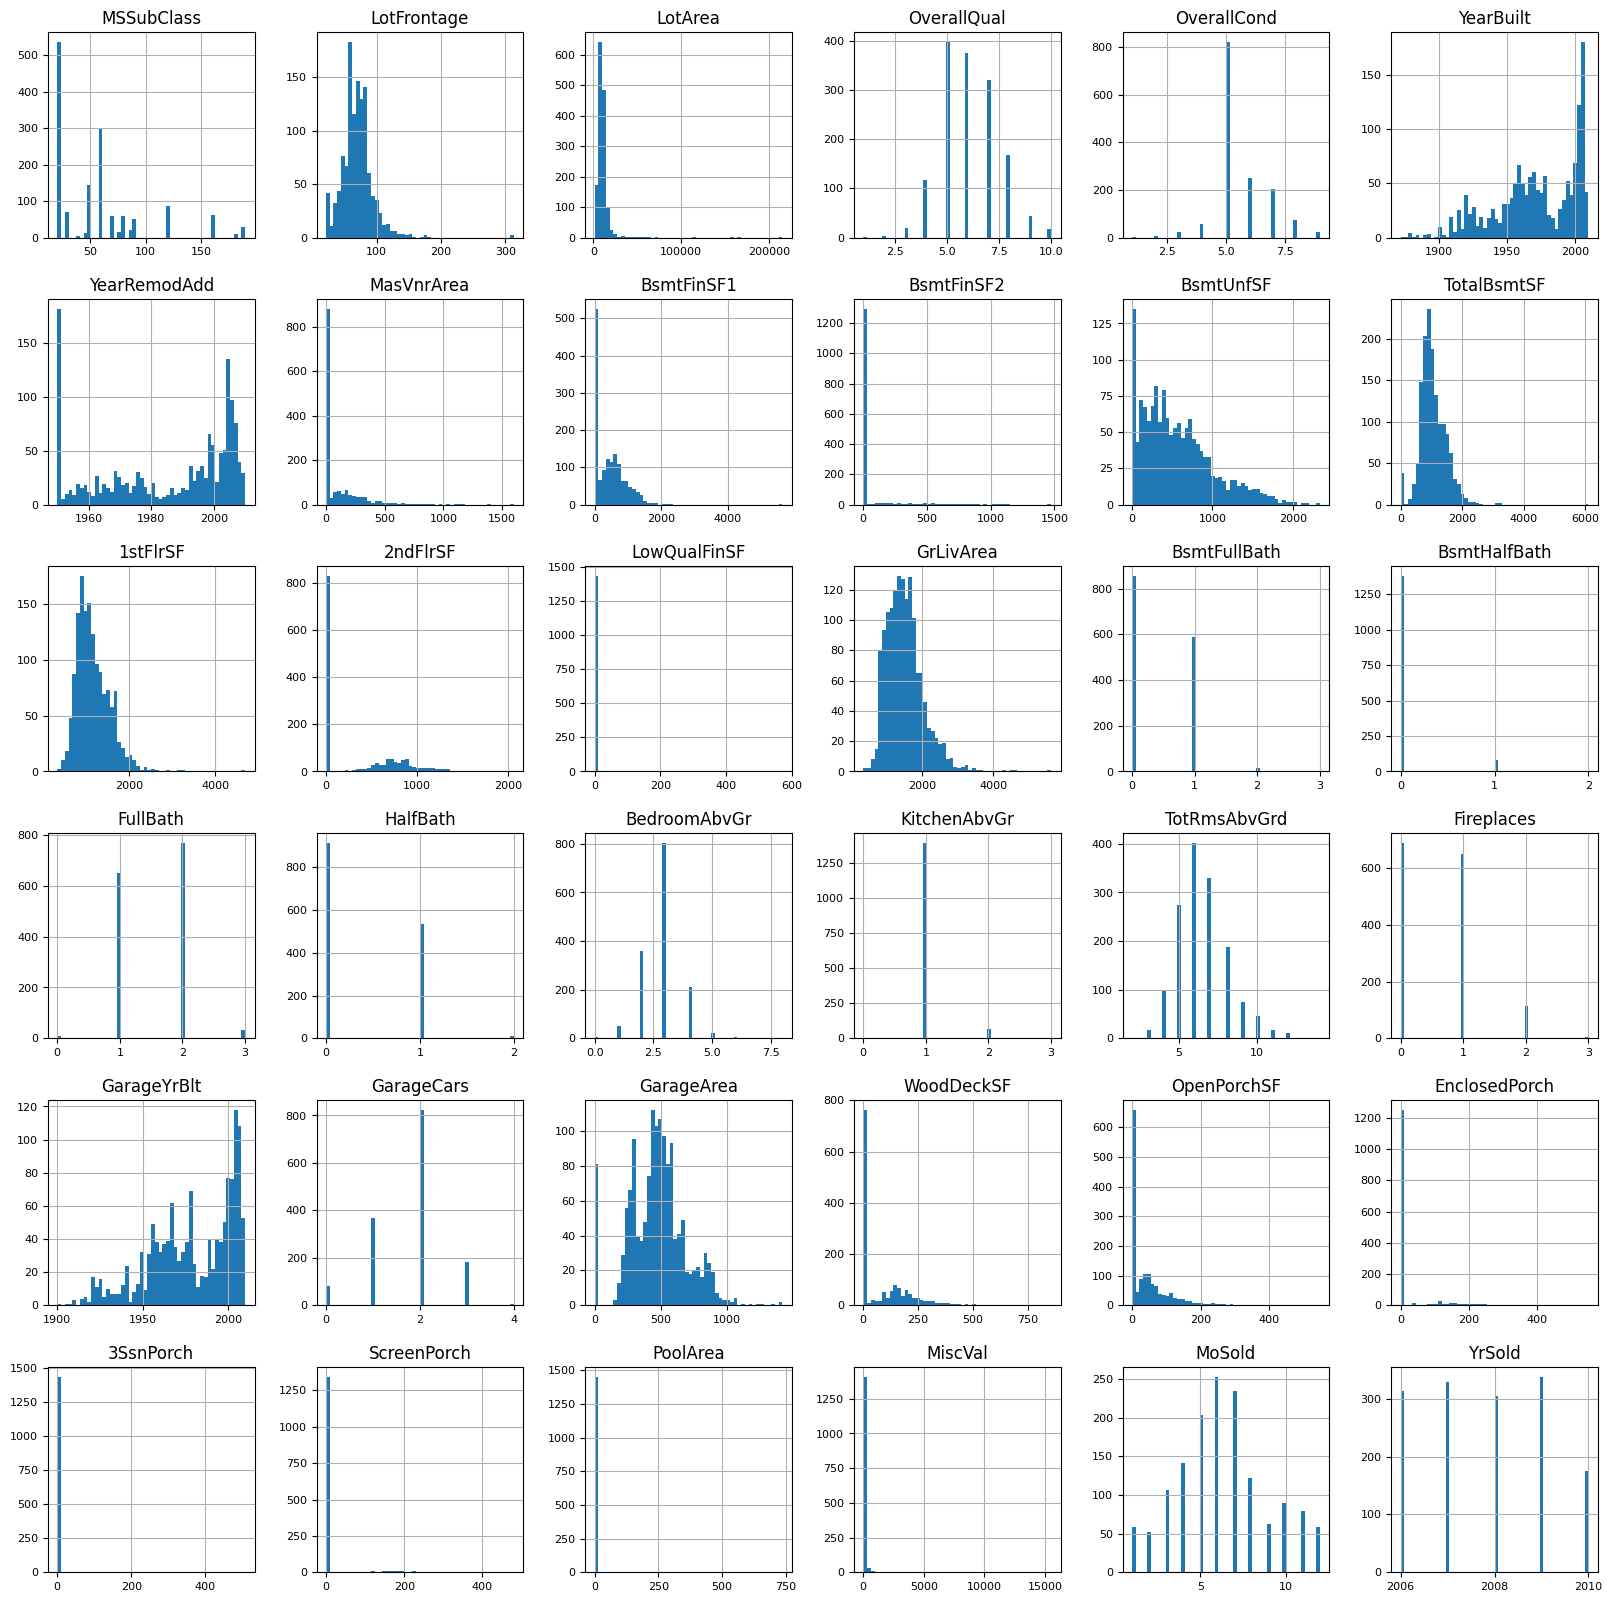

In [559]:
train_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

I considered removing some of these columns if they could be unrelated to a house's sale price but I think all of these are useful so they will be kept. Let's take a look at the categorical features this time.

In [560]:
# Create a new DataFrame for categorical data only
train_cat = data_train.select_dtypes(include = ['O'])
train_cat.head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4       RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0      CollgCr       Norm  ...     Attchd          RFn         TA         TA   
1      Veenker      Feedr  ...     Attchd          RFn         TA         TA   
2      CollgCr       Norm  ...     Attchd          RFn         TA         TA   
3      Crawfor       Norm  ...     Detchd          Unf         TA         TA   
4      NoRidge       Norm  ...     Attchd          RFn         TA         TA   

  PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0          Y    NaN   NaN         NaN       WD        Normal  
1          Y    NaN   NaN         NaN       WD        Normal  
2          Y    NaN   NaN         NaN       WD        Normal  
3          Y    NaN   NaN         NaN       WD       Abnorml  
4          Y    NaN   NaN         NaN       WD        Normal  

[5 rows x 43 columns]

Seems like most of our features are categorical. Let's plot their distributions as well.

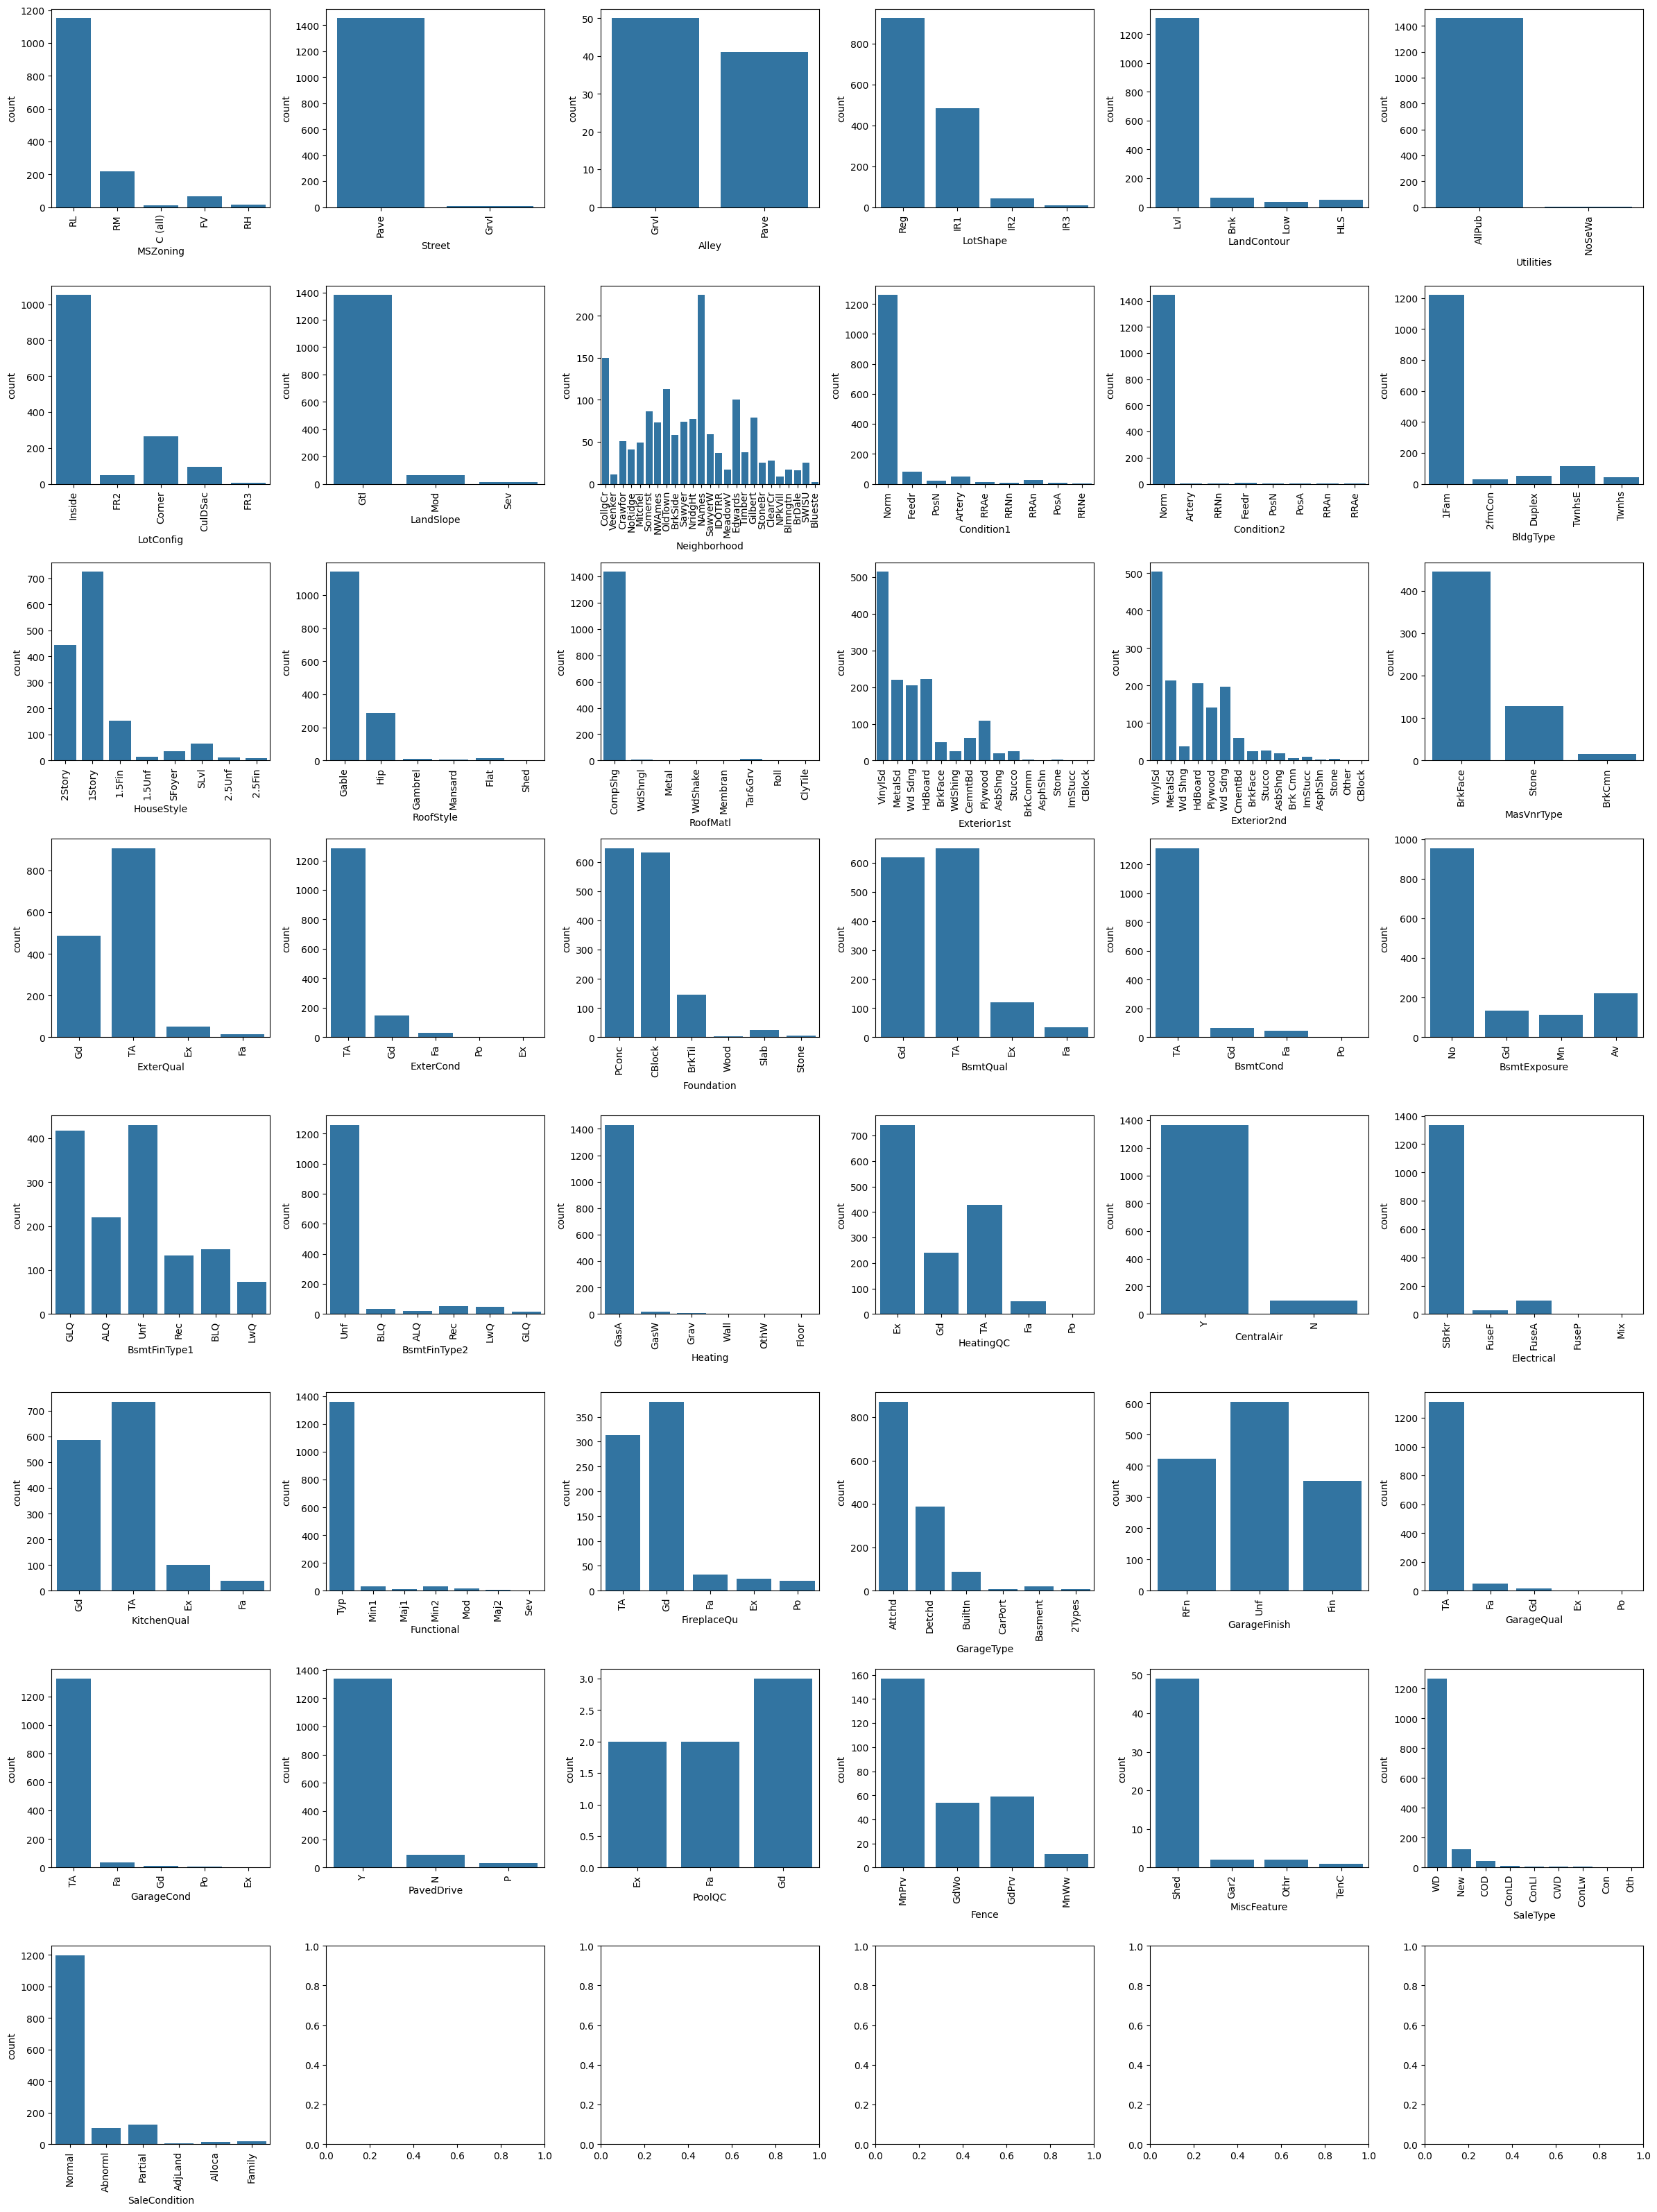

In [561]:
# Create a composed plot with matplotlib.subplots()
fig, axs = plt.subplots(8, 6, figsize=(24, 32))

# Flatten the axes so that iterating is easier
axs = axs.flatten()

# Iterate through each feature/column and plot their countplots
for i, col in enumerate(train_cat.columns):
  sns.countplot(x=train_cat[col], ax=axs[i])
  axs[i].tick_params(axis='x', rotation=90)

# Use matplotlib.tight_layout() to prevent overlapping
fig.tight_layout()


As it is not desirable to directly enumerate categorical values. For example, it does not make sense to give paved a value of 0 and gravel a value of 1 for the **Street** feature. We would rather use an approach called **One-Hot Encoding** which is basically to give every unique entry its own binary value like;
* Paved = 1
* Gravel = 0

so that this means there is a paved street and not gravel around the house. It should be noted that only one of these values can be 1 (True) at a time but all can be 0 (False) if that entry is missing. <br><br>
Also, numerical features' ranges vary by a large margin in the dataset. If we take a look at the features like **FullBath** which is a number of full bathrooms above grade and **TotalLotArea** which can get a value up to 200000~ as can be seen from the plots. So we should definitely normalize the numerical features so that we end up with values that are standardized. For example, limiting their range to 0-1 interval. <br>
This
* helps models converge faster
* prevents the **NaN** trap which is when a value exceeds the floating point precision limit so that eventually every number in the model became **NaN**

There are a few normalization methods in my mind so let's try to decide on which one would be the best fit for our dataset.
- **Linear Scaling** : Best when
  - there are few or no outliers, and the outliers aren't extreme.
  - distribution of the data is approximately uniform.
- **Z-Score Scaling** : Best when
  - the distribution resembles a normal distribution or something close to it.
- **Log Scaling** : Best when
  - low values of x have very high values of y
  - as the values of x increase, values of y quickly decrease
  
I might use something completely different who knows...

# 2 - Data Preprocessing
This has been a huge information dump but lets just examine what portion of each feature is missing now to see if we want to remove anything.

In [562]:
# Use the DataFrame.isna().sum() with a condition to get all the counts of nan values for every column that has at least one, then turn it into a percentage
train_num.isna().sum()[data_train.isna().sum() > 0] / len(data_train) * 100

LotFrontage    17.739726
MasVnrArea      0.547945
GarageYrBlt     5.547945
dtype: float64

In [563]:
# Do the same with categorical features
train_cat.isna().sum()[data_train.isna().sum() > 0] / len(data_train) * 100

Alley           93.767123
MasVnrType      59.726027
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

Turns out most of the features that can take the value of **NaN** are categorical and it makes sense. A house does not necessarily have to have Pool for example so it can have a value of 0 for each **One-Hot Encoded** feature. Even the numerical data makes sense as if a property does not have a garage for example, it should not have a **GarageYrBlt** value. Though, this is a problem as we do not want any **NaN** values in our dataset and I am going to only scale the numerical ones so the **NaN** values are not going to disappear. To remedy this, I will
- Take the median for LotFrontage
- Set MasVnrArea to 0
- Set GarageYrBlt to the same as YearBuilt

hopefully to get rid of those in the most reasonable way possible.<br><br>

As it is the easiest part, let's turn categorical features into One-Hot Encodings.


In [564]:
# Handle missing data
train_num['LotFrontage'] = train_num['LotFrontage'].fillna(train_num['LotFrontage'].median())
train_num['MasVnrArea'] = train_num['MasVnrArea'].fillna(0)
train_num['GarageYrBlt'] = train_num['GarageYrBlt'].fillna(train_num['YearBuilt'])

Now let's take **One-Hot-Encode** the categorical features.

In [565]:
# Get the categorical columns
categorical_columns = train_cat.columns.tolist()

# Specify encoder
encoder = OneHotEncoder(sparse_output=False)

# Create a Tensor for the one-hot-encoded features
one_hot_encoded = encoder.fit_transform(data_train[categorical_columns])

# Create a DataFrame from the Tensor with the appropriate column names
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Display a portion of it
one_hot_df.head()

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0               0.0          0.0          0.0          1.0          0.0   
1               0.0          0.0          0.0          1.0          0.0   
2               0.0          0.0          0.0          1.0          0.0   
3               0.0          0.0          0.0          1.0          0.0   
4               0.0          0.0          0.0          1.0          0.0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  Alley_nan  ...  \
0          0.0          1.0         0.0         0.0        1.0  ...   
1          0.0          1.0         0.0         0.0        1.0  ...   
2          0.0          1.0         0.0         0.0        1.0  ...   
3          0.0          1.0         0.0         0.0        1.0  ...   
4          0.0          1.0         0.0         0.0        1.0  ...   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0.0           0.0           0.0          1.0   
1             0.0           0.0           0.0          1.0   
2             0.0           0.0           0.0          1.0   
3             0.0           0.0           0.0          1.0   
4             0.0           0.0           0.0          1.0   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                    0.0                    0.0                   0.0   
1                    0.0                    0.0                   0.0   
2                    0.0                    0.0                   0.0   
3                    1.0                    0.0                   0.0   
4                    0.0                    0.0                   0.0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                   0.0                   1.0                    0.0  
1                   0.0                   1.0                    0.0  
2                   0.0                   1.0                    0.0  
3                   0.0                   0.0                    0.0  
4                   0.0                   1.0                    0.0  

[5 rows x 267 columns]

Now we have 267 columns of **True** or **False** values for categorical features. For the next step, let's try to use Scikit-Learn's PowerTransformer to normalize the data instead of the other three methods as I don't think any of them fit well to all (or even most) features.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

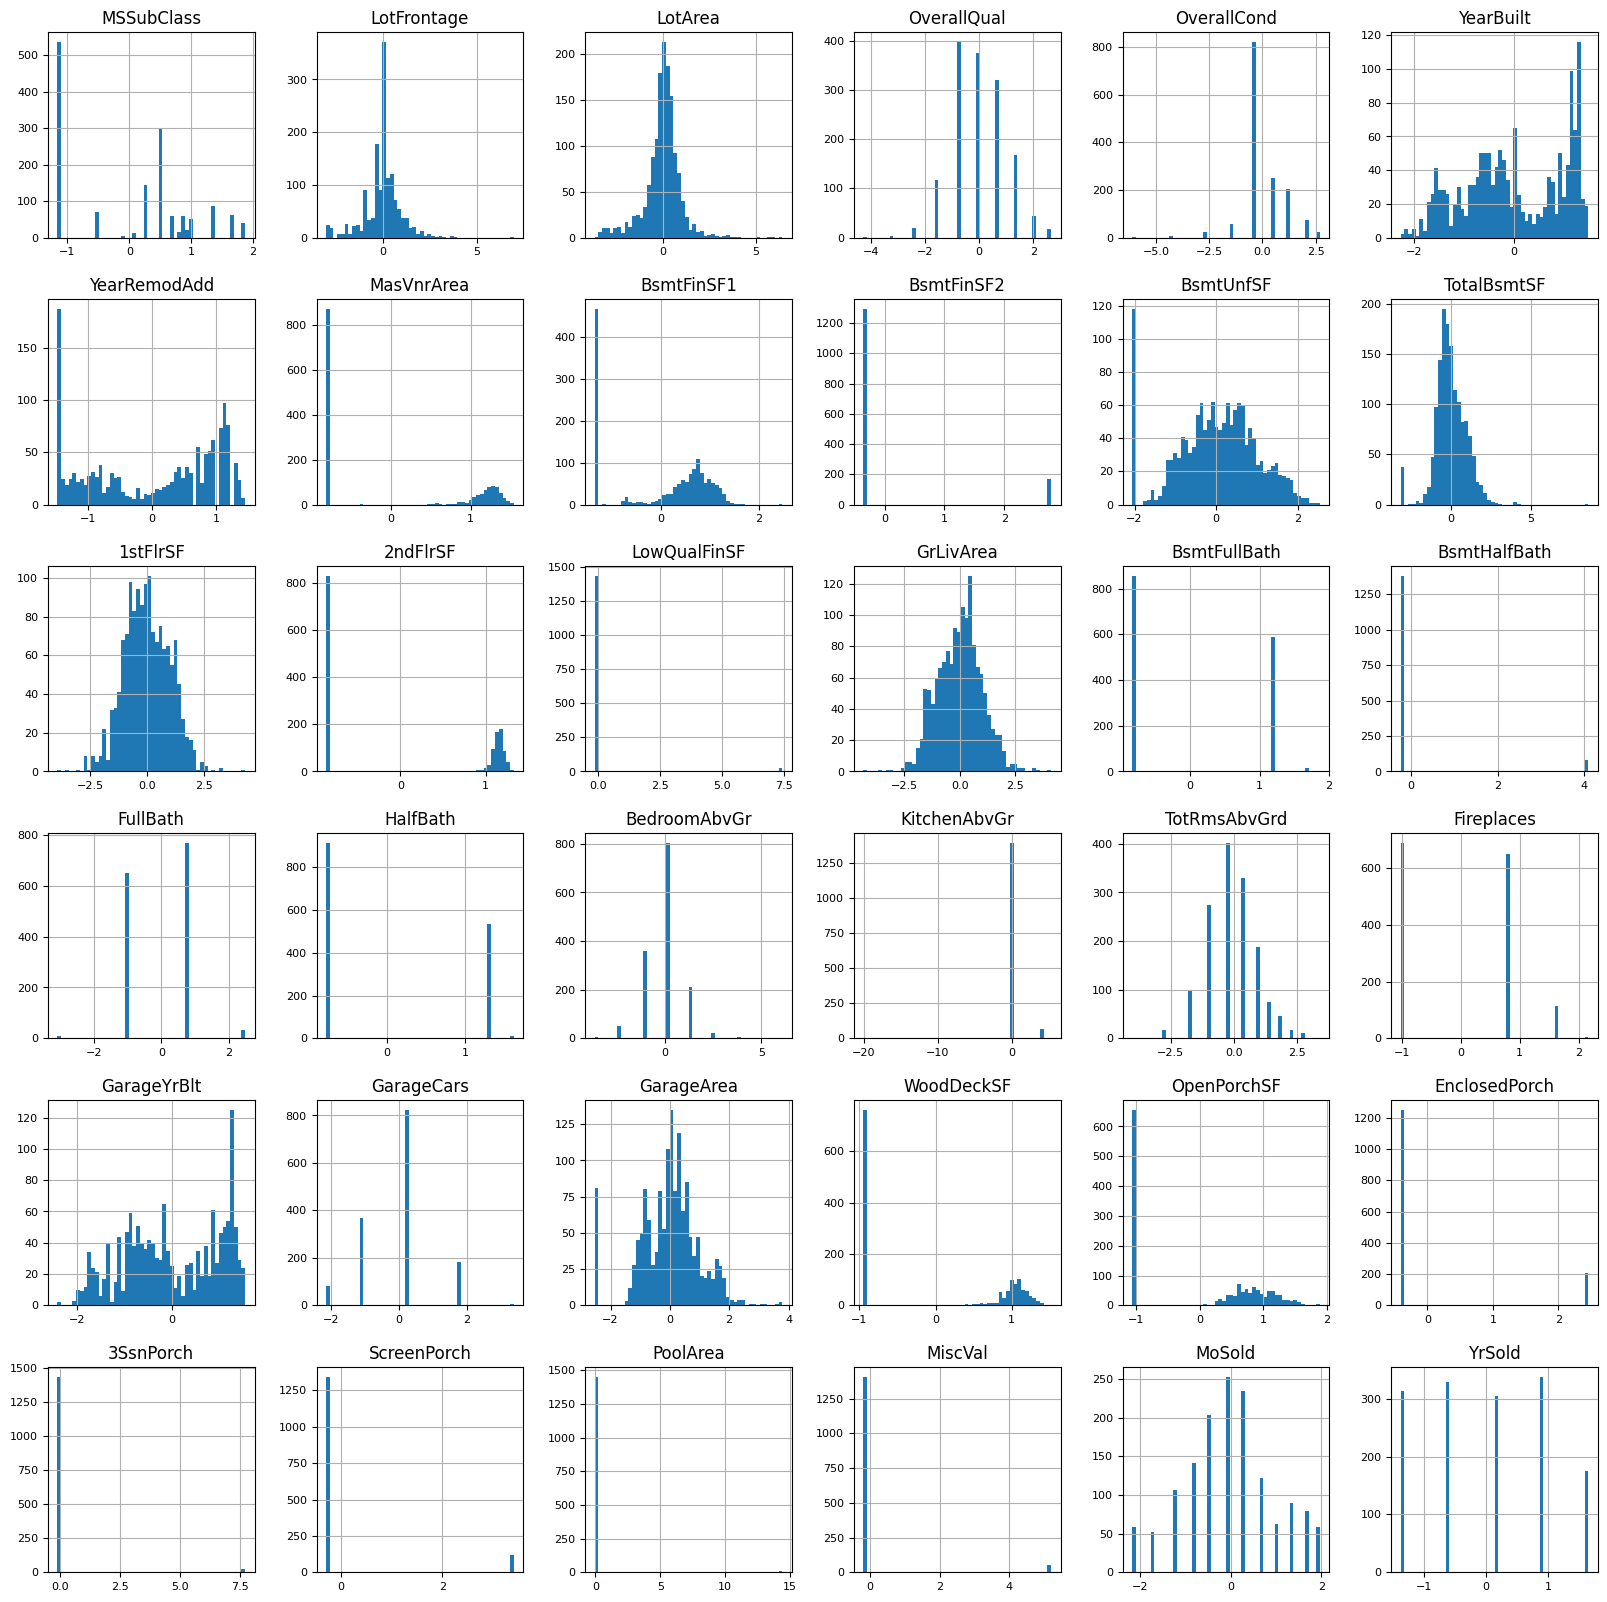

In [566]:
# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform only the numerical the data
train_num_normalized = pd.DataFrame(pt.fit_transform(train_num), columns=pt.get_feature_names_out(train_num.columns))

# Plot them after the transformation
train_num_normalized.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

These distributions look a lot better than how they were originally. The scale problem is solved as all the numerical features now span a similar range. Finally let's create the actual training dataset that we are going to use to train models.

In [567]:
# Concatenate the scaled numerical features and one-hot-encoded categorical values
data_train_normalized = pd.concat([train_num_normalized, one_hot_df], axis=1)

# Display a portion of it
data_train_normalized.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.493460    -0.146062 -0.141171     0.667499    -0.477387   1.151867   
1   -1.164269     0.546852  0.105609    -0.042192     2.011352   0.006695   
2    0.493460    -0.000631  0.413721     0.667499    -0.477387   1.055357   
3    0.698191    -0.397299  0.095490     0.667499    -0.477387  -1.629540   
4    0.493460     0.718695  0.877127     1.350924    -0.477387   1.007861   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0      0.908055    1.230708    0.797537   -0.359384  ...             0.0   
1     -0.621670   -0.818452    1.011471   -0.359384  ...             0.0   
2      0.835594    1.193873    0.571325   -0.359384  ...             0.0   
3     -0.863478   -0.818452    0.142272   -0.359384  ...             0.0   
4      0.694898    1.333038    0.750541   -0.359384  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          1.0                    0.0   
1           0.0           0.0          1.0                    0.0   
2           0.0           0.0          1.0                    0.0   
3           0.0           0.0          1.0                    1.0   
4           0.0           0.0          1.0                    0.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  
4                   1.0                    0.0  

[5 rows x 303 columns]

Now that I have the **normalized** and **one-hot-encoded** features. I will convert this DataFrame into a **PyTorch Tensor** so that we can start use it for training easily. Let's convert the labels as well.

In [568]:
# Convert DataFrame to a PyTorch Tensor
X_train = torch.tensor(data_train_normalized.values, dtype=torch.float32)

# Display the shape of the tensors
print(f"Training Data Shape : {X_train.shape}")

Training Data Shape : torch.Size([1460, 303])


# 3 - Model Building
Now that our data is ready to go. I will initialize the Linear Regression Model with **PyTorch**. I will be using **RMSE (Root Mean Squared Error)** as the loss function to abide by the competition rules. Turns out the loss is calculated between the logarithms of the Sale Prices so I will need to transform the label DataFrame. I will also use the **AdamW** optimizer.

In [569]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [570]:
# Create RMSE Loss (MSE but inside a square root)
class RMSELoss(torch.nn.Module):
    def __init__(self, eps = 1e-6):
        super(RMSELoss,self).__init__()
        self.eps = eps

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y) + self.eps)
        return loss

In [571]:
# Transform the labels by calculating their logarithms
data_y_log = np.log1p(data_y)

# Transform the labels to a tensor
y_train = torch.tensor(data_y_log.values, dtype=torch.float32).view(-1, 1)
print(f"Training Labels Shape : {y_train.shape}")

Training Labels Shape : torch.Size([1460, 1])


Okay. Everything should be ready to start our first model training. I think training for 150 epochs should be reasonable. Don't forget that training for too long has the risk of overfitting the model. At first I need to implement the training loop function. I will add optional print statements and plots as well to visualise our model's performance.

In [584]:
# Initialize training function
def train_model(model, dataset_train, labels_train, epochs = 150, regularization_type = None, lambda_reg = 0.01, val = False, dataset_cv = None, labels_cv = None) :
  # To track losses
  losses = []

  # Select Loss Function and optimizer
  criterion = RMSELoss(eps=1e-6)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0)

  for epoch in range(epochs):

      # Perform a forward pass (prediction)
      pred_y = model(dataset_train)

      # Compute and print loss
      loss = criterion(pred_y, labels_train)

      # Track losses
      losses.append(loss.item())

      # Apply L1 regularization
      if regularization_type == 'L1':
          l1_norm = sum(p.abs().sum() for p in model.parameters())
          loss = loss + lambda_reg * l1_norm
      # Apply L2 regularization
      elif regularization_type == 'L2':
          l2_norm = sum(p.pow(2).sum() for p in model.parameters())
          loss = loss + lambda_reg * l2_norm

      # Zero gradients, perform a backward pass, and update the weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Optional print for epoch and loss values
      # print(f"epoch {epoch + 1}, loss {loss.item()}")
  print(f"Final loss = {losses[-1]}")

  if val:
    with torch.no_grad():
      val_pred = model(dataset_cv)
      val_rmse = criterion(val_pred, labels_cv).item()
      print(f"Validation RMSE = {val_rmse}")

  # Plot important findings
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs = axs.flatten()

  axs[0].plot(losses)
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('RMSE Loss')
  axs[0].set_title('Training Loss')

  # We aren't going to update the model so we use no_grad()
  with torch.no_grad():
      predictions = model(dataset_train).numpy()

  axs[1].scatter(labels_train.numpy(), predictions, alpha=0.5)
  axs[1].plot([labels_train.min(), labels_train.max()], [labels_train.min(), labels_train.max()], 'r--')  # perfect line
  axs[1].set_xlabel('Actual (log price)')
  axs[1].set_ylabel('Predicted (log price)')
  axs[1].set_title('Predictions vs Actuals')

  # Calculate residuals
  residuals = labels_train.numpy() - predictions

  axs[2].scatter(predictions, residuals, alpha=0.5)
  axs[2].axhline(y=0, color='r', linestyle='--')
  axs[2].set_xlabel('Predicted')
  axs[2].set_ylabel('Residual')
  axs[2].set_title('Residual Plot')

  fig.tight_layout()

  return residuals

Let's initialize our baseline model and train it.

Final loss = 0.09332945942878723


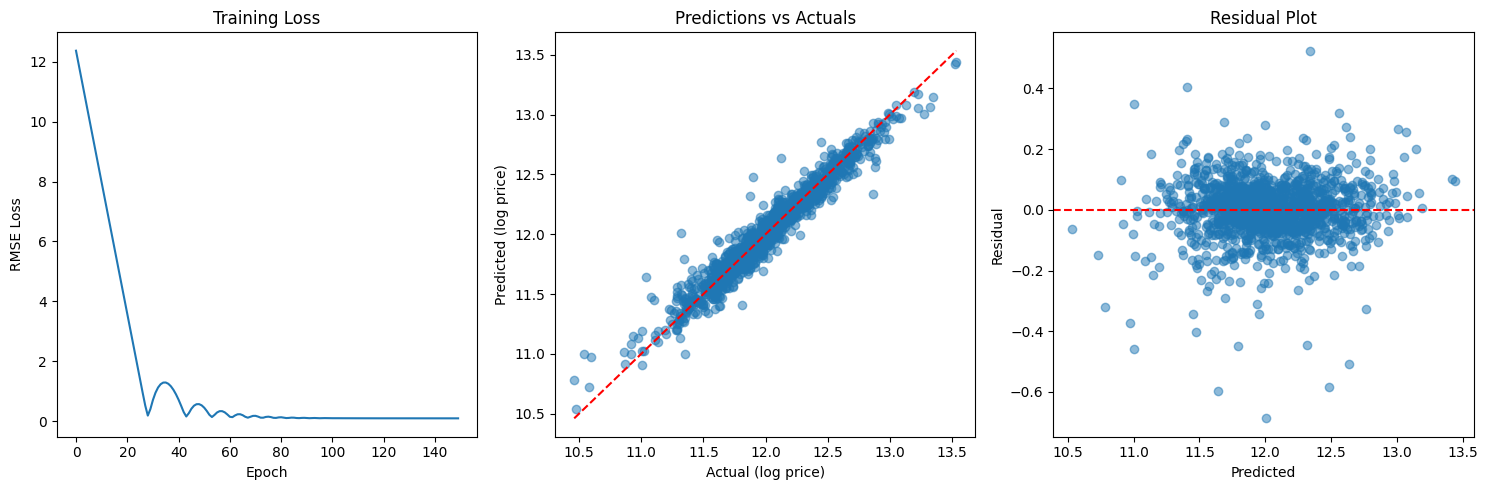

In [585]:
# Model initialization
lr_model = LinearRegressionModel(input_dim=X_train.shape[1])

# Call the training function for the baseline model
residuals_lr = train_model(lr_model, X_train, y_train, 150)

1. The loss function looks pretty good, it converges well. There is an oscillation between epochs ~24-75 but it stabilizes after that.

2. Points hug the line well enough. The correlation looks strong except for the slight spread at lower prices.

3. The points are randomly scattered around 0 and there is no obvious pattern which is a good indicator that the model is learning the relationships well.

Now let's implement L1 (Lasso) and L2 (Ridge) Regularization to our model and see how it performs. I will set a seed for reproducability as well.

Final loss = 0.09606374055147171


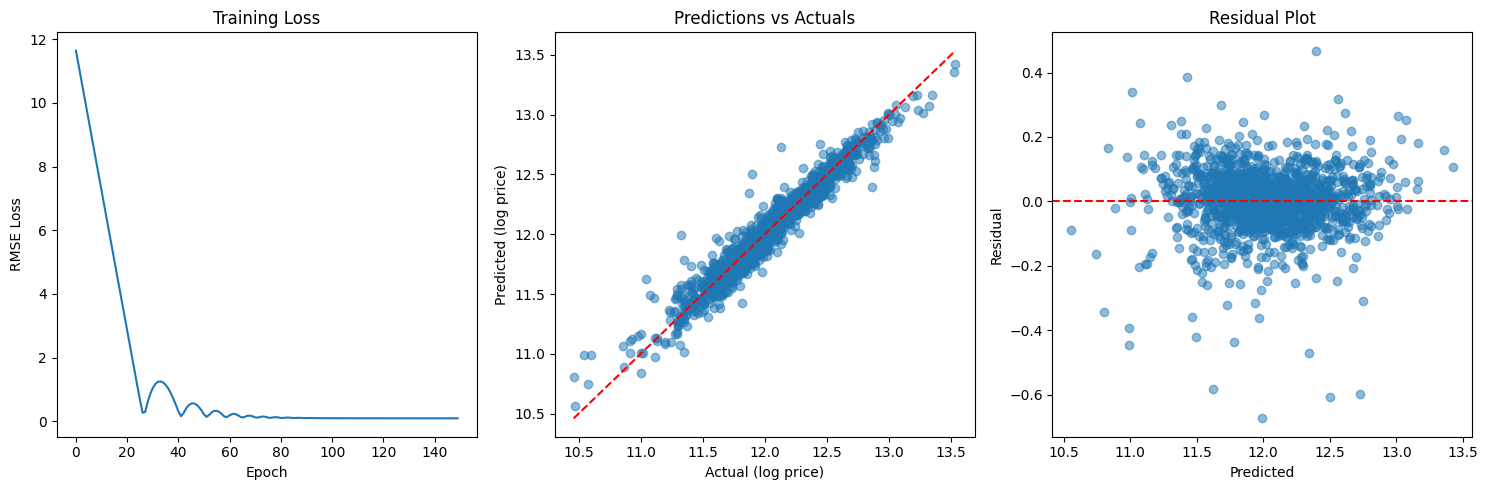

In [574]:
# Initialize a model for L1 regularization
lr_model_l1 = LinearRegressionModel(input_dim=X_train.shape[1])

# Train the new model
train_model(lr_model_l1, X_train, y_train, 150, "L1", 0.001)

With these hyperparameters, L1 regularized model does not seem like it is superior or inferior to the baseline model. Let's try L2 as well.

Final loss = 0.09433934837579727


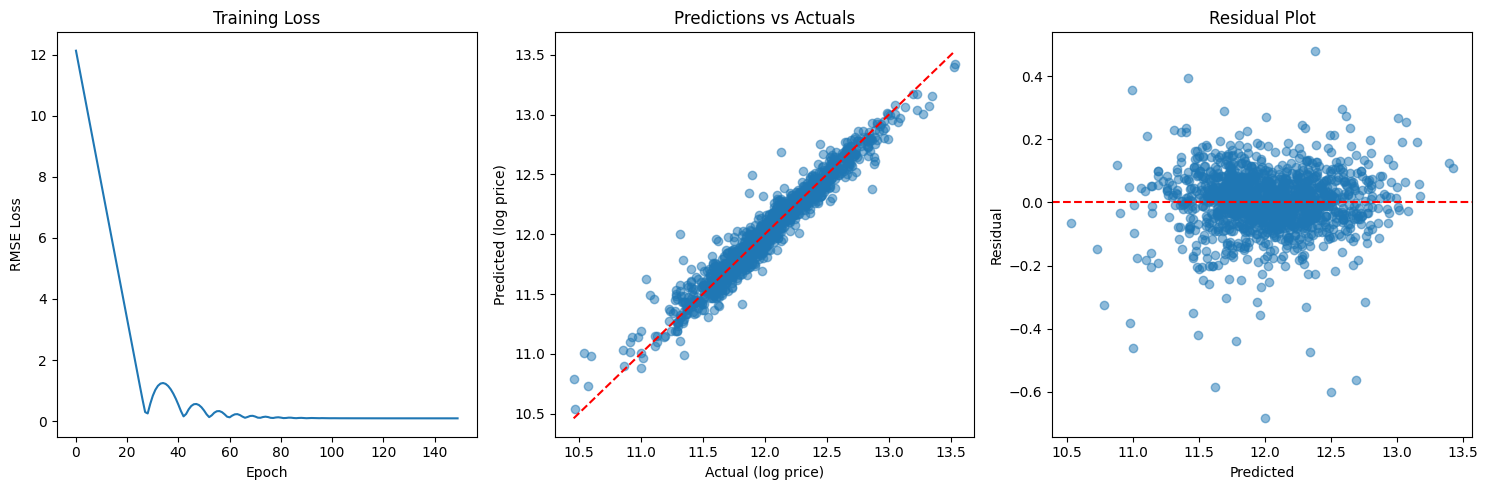

In [575]:
# Initialize model
lr_model_l2 = LinearRegressionModel(input_dim=X_train.shape[1])

# Train model
train_model(lr_model_l2, X_train, y_train, 150, "L2", 0.001)

Hmm. It is difficult to tell the performance difference from only these plots as they are too similar to each other. How about I introduce a new approach?
# 4 - Evaluation
Let's try to split our dataset into two parts (Train, Cross Validation) so that we only train on the Training dataset and compare on the Cross Validation dataset to see how well the models generalize. I will separate them into 80% Training and 20% Cross Validation.

In [576]:
# Use Scikit-Learn's train_test_split() method to easily split the dataset into parts, also use a random_state variable for reproducability
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training Data Shape : {X_tr.shape}")
print(f"Cross Validation Data Shape : {X_cv.shape}")
print(f"Training Labels Shape : {y_tr.shape}")
print(f"Cross Validation Labels Shape : {y_cv.shape}")

Training Data Shape : torch.Size([1168, 303])
Cross Validation Data Shape : torch.Size([292, 303])
Training Labels Shape : torch.Size([1168, 1])
Cross Validation Labels Shape : torch.Size([292, 1])


Baseline
Final loss = 0.08983875066041946
Validation RMSE = 0.1327408254146576


L1 Regularized
Final loss = 0.09232019633054733
Validation RMSE = 0.12921884655952454


L2 Regularized
Final loss = 0.0907386988401413
Validation RMSE = 0.1281326562166214


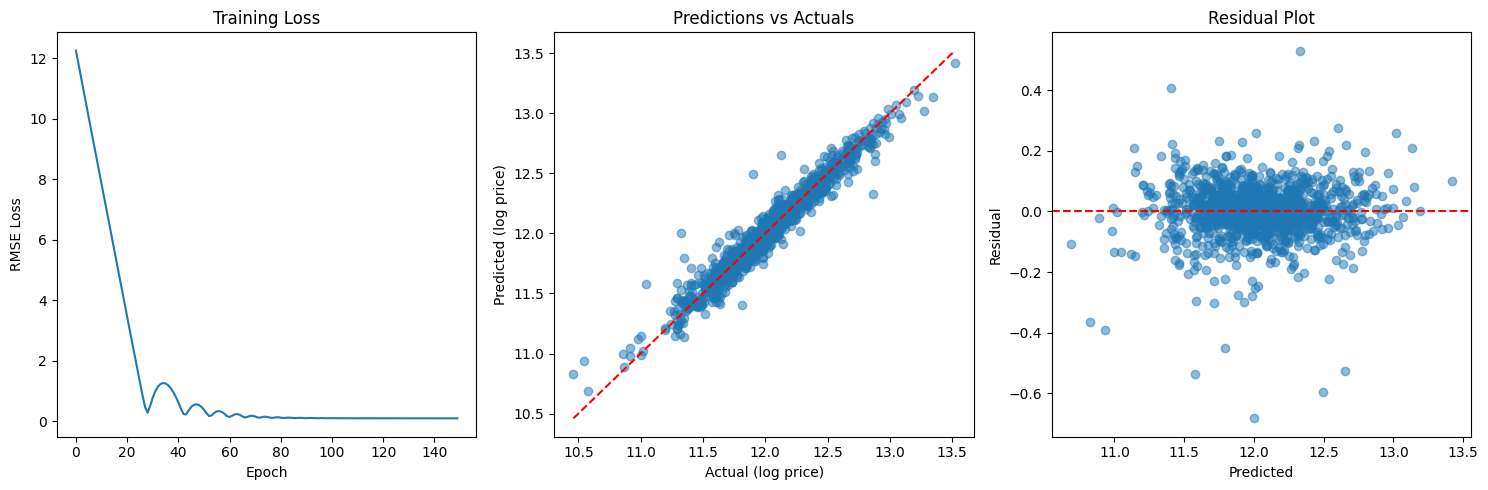

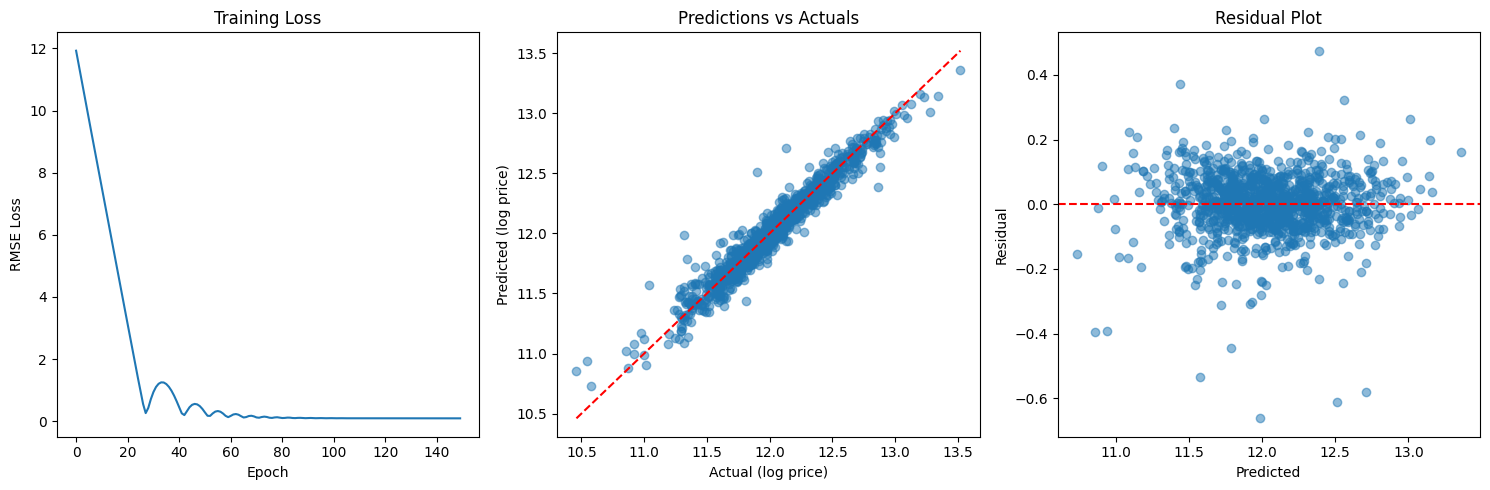

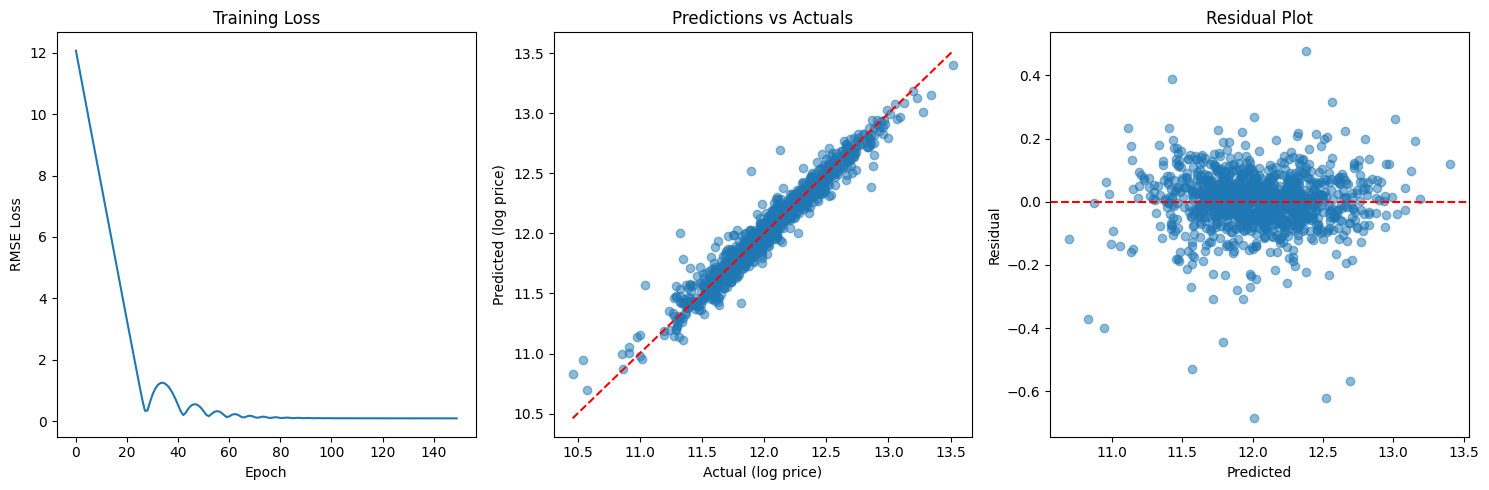

In [577]:
# Reinitialize and train models on the Training dataset
lr_model = LinearRegressionModel(input_dim=X_train.shape[1])
lr_model_l1 = LinearRegressionModel(input_dim=X_train.shape[1])
lr_model_l2 = LinearRegressionModel(input_dim=X_train.shape[1])

print("Baseline")
train_model(lr_model, X_tr, y_tr, 150, None, 0, True, X_cv, y_cv)
print("\n")
print("L1 Regularized")
train_model(lr_model_l1, X_tr, y_tr, 150, "L1", 0.001, True, X_cv, y_cv)
print("\n")
print("L2 Regularized")
train_model(lr_model_l2, X_tr, y_tr, 150, "L2", 0.001, True, X_cv, y_cv)

The models' performances on the training dataset were similar. In fact, the baseline model had a better loss than the regularized ones. Though, the performance on the Cross Validation dataset is not the same. L2 regularized model generalizes better.
# 5 - Feature Engineering
Now, let's try adding polynomial features to check if the model learns better or worse with them. I will be adding them to a separate dataset so that I do not run **Power Transformer** twice on the same data. For now I should pick some features that we can use for this as feature count explosion is not desirable either. To decide on features to try polynomial features on, I will create some plots and visualise their relationships.

In [578]:
# Copy the numerical features
train_num_poly = train_num
train_num_poly.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
0          2003       196.0         706           0  ...         548   
1          1976         0.0         978           0  ...         460   
2          2002       162.0         486           0  ...         608   
3          1970         0.0         216           0  ...         642   
4          2000       350.0         655           0  ...         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           61              0          0            0         0   
1         298            0              0          0            0         0   
2           0           42              0          0            0         0   
3           0           35            272          0            0         0   
4         192           84              0          0            0         0   

   MiscVal  MoSold  YrSold  
0        0       2    2008  
1        0       5    2007  
2        0       9    2008  
3        0       2    2006  
4        0      12    2008  

[5 rows x 36 columns]

At first, let's plot every numerical feature against our label so I can see if a curve could help instead of a straight line.

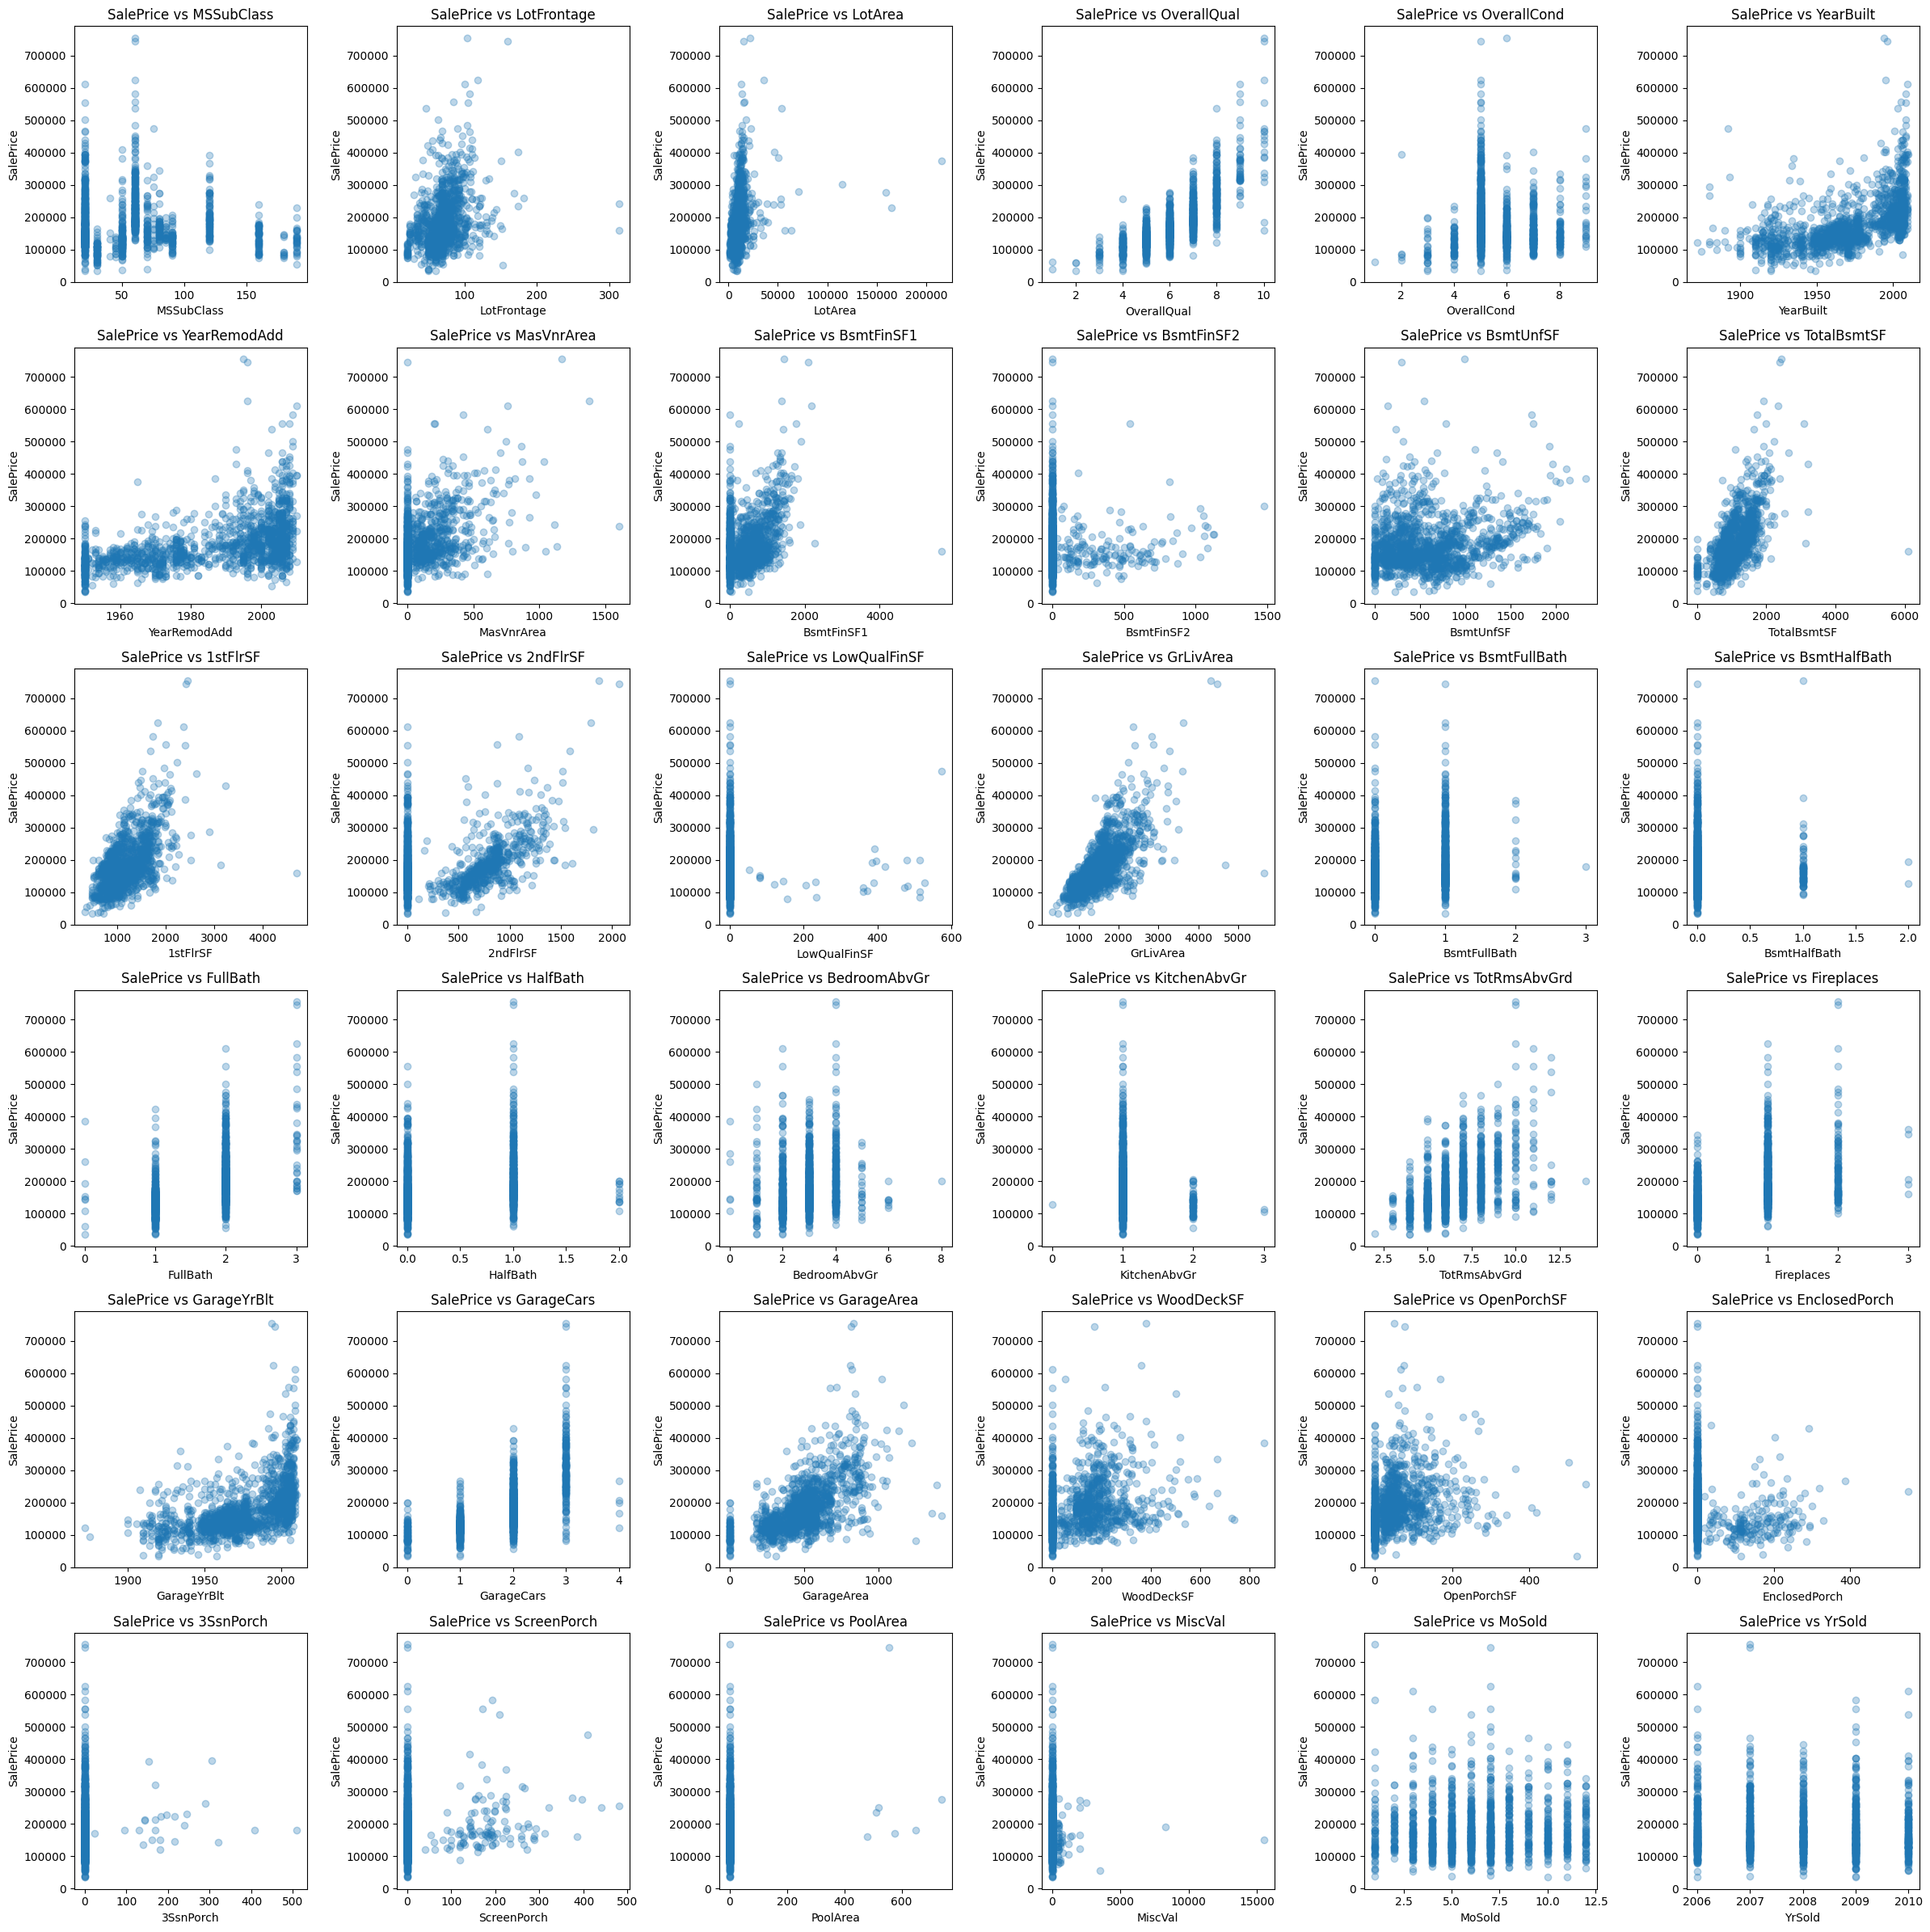

In [583]:
# Plot every numerical feature against SalePrice
fig, axs = plt.subplots(6, 6, figsize=(24, 24))
axs = axs.flatten()

for ax, feat in zip(axs, train_num):
    ax.scatter(train_num[feat], data_y, alpha=0.3)
    ax.set_xlabel(feat)
    ax.set_ylabel('SalePrice')
    ax.set_title(f'SalePrice vs {feat}')

fig.tight_layout()

Looking at these plots. We can see that some of them have an accelerating pattern which are great candidates for polynomial features. Mainly **OverallQual**, **YearBuilt** and **YearRemodAdd**. This implies that they have a more significant gap in their y values as x increases and thus could be helpful for the model to learn. On the other hand, **GrLivArea** and **TotalBsmtSF** features have plots that seem flattened at higher values which could also be useful to introduce to our dataset for more complex relationships. To further justify our choices, let's try plotting each numerical feature's residuals.

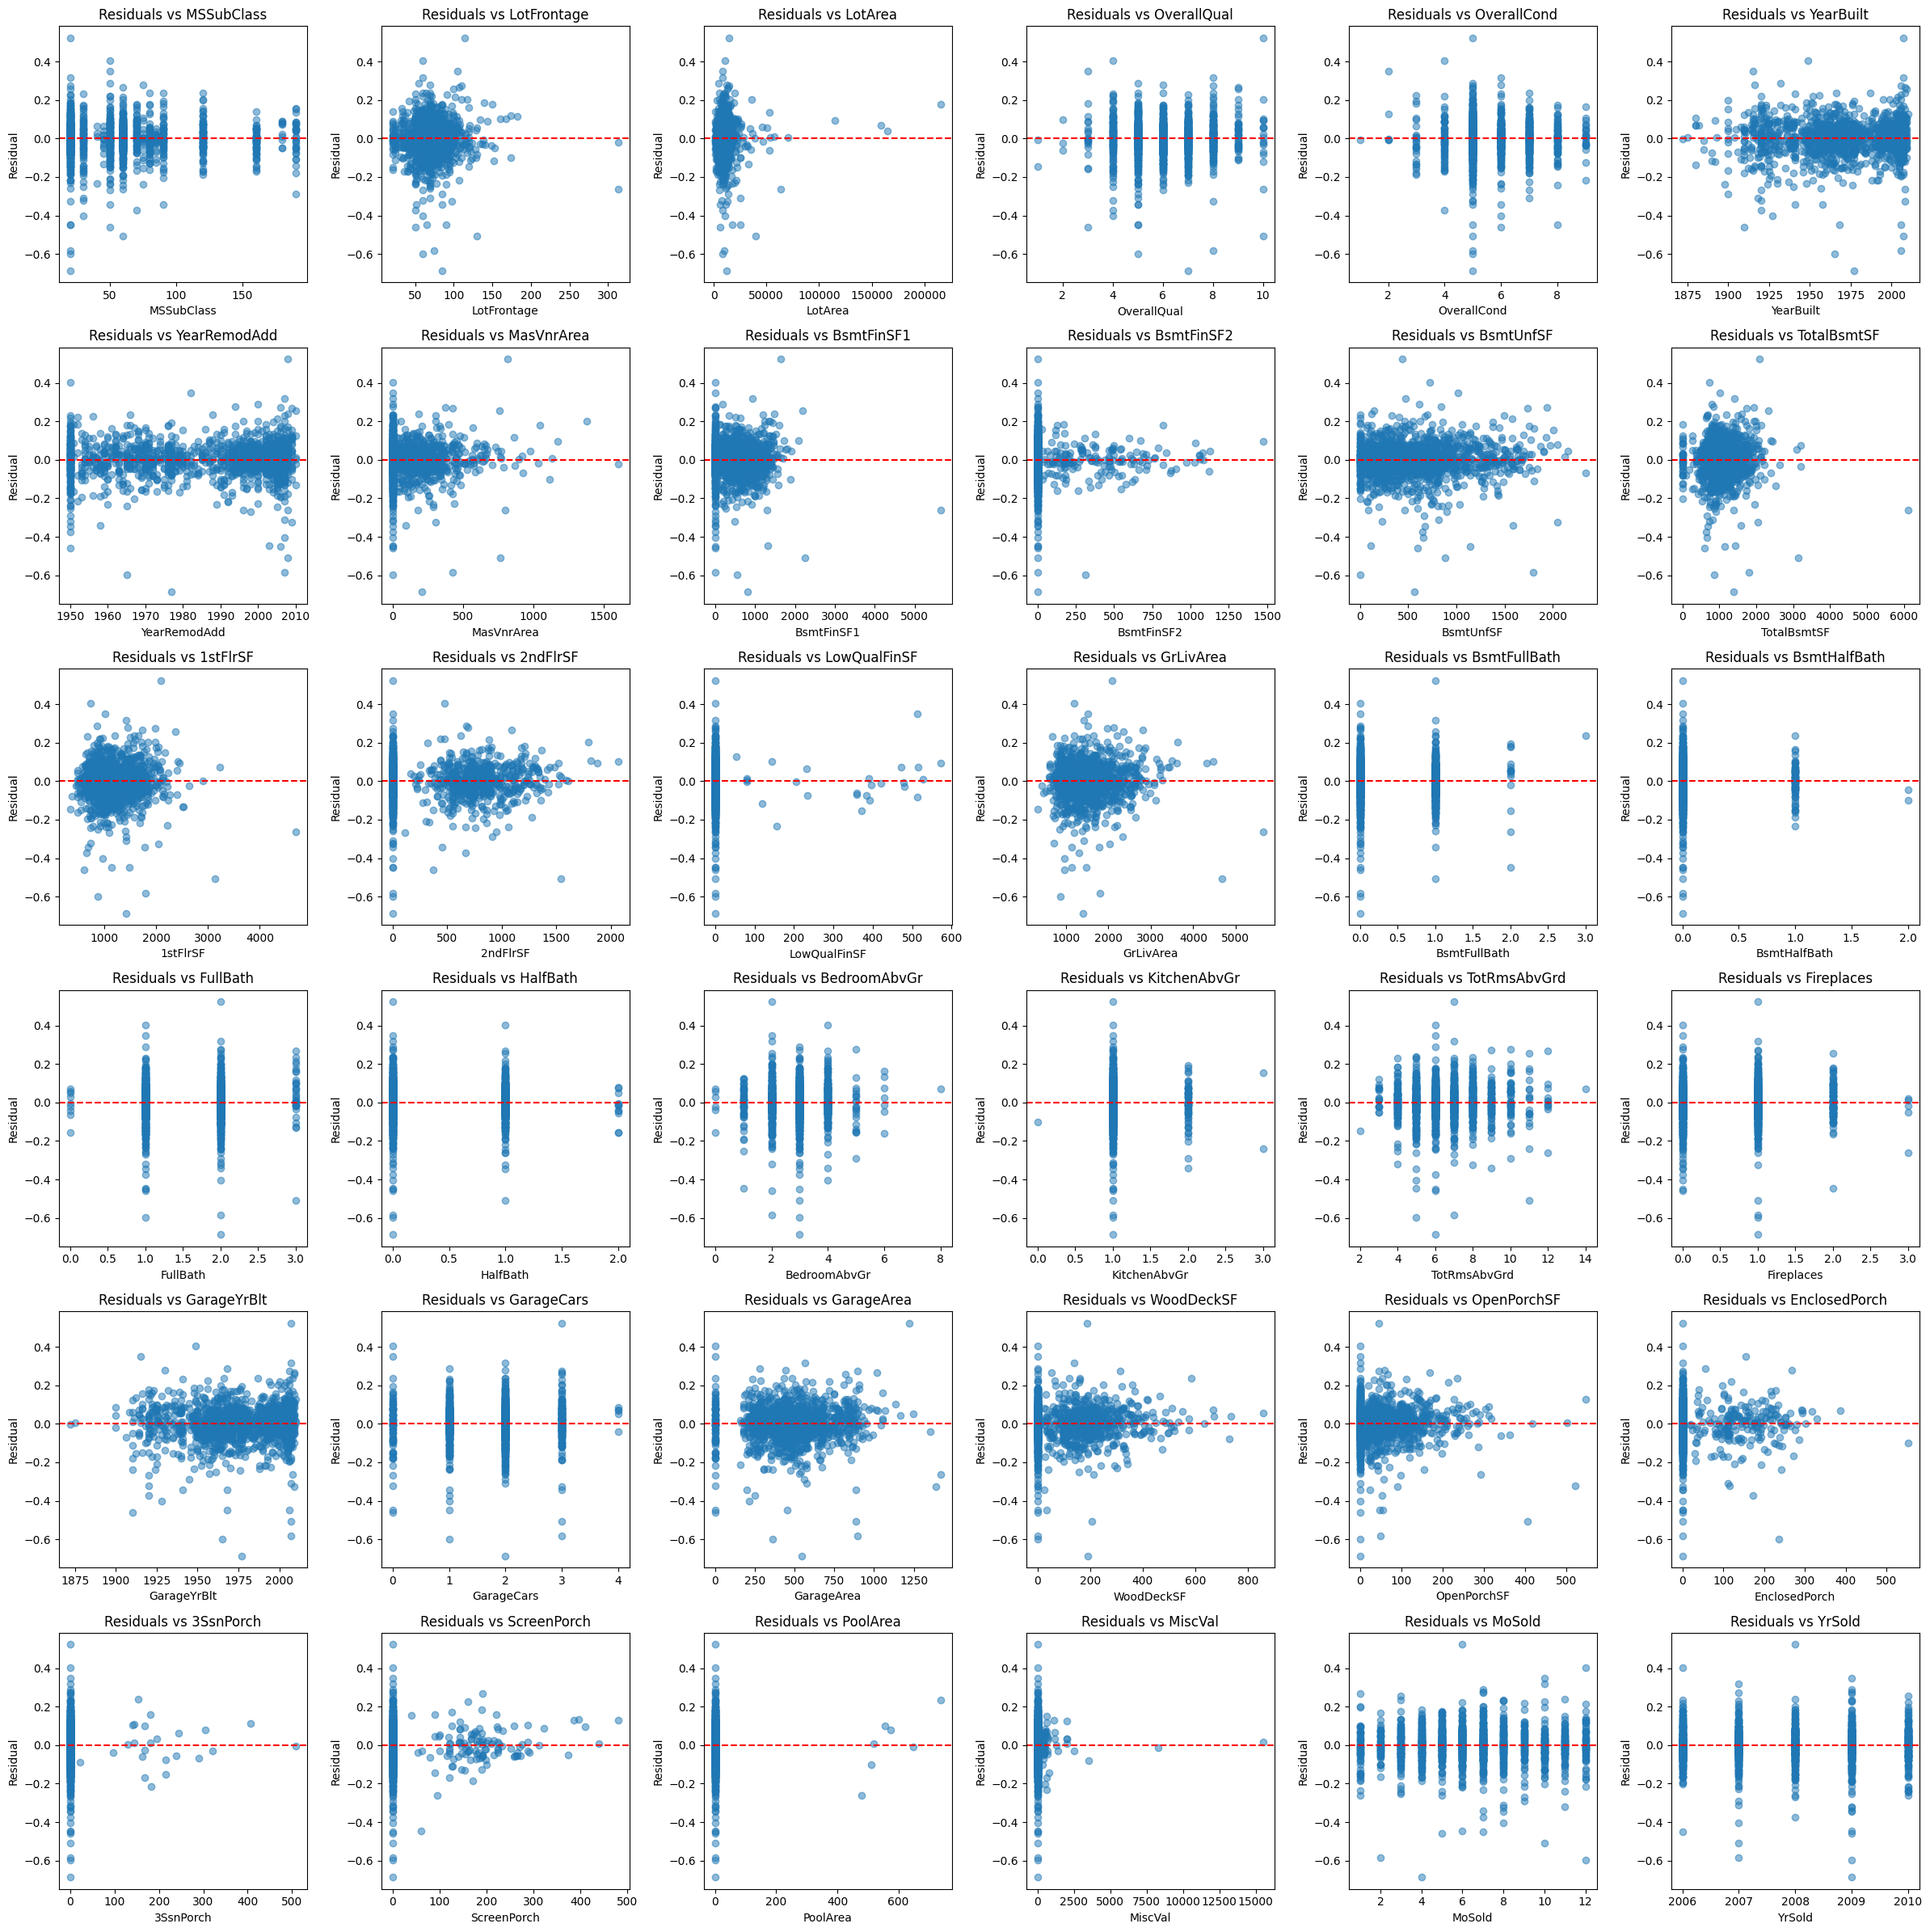

In [586]:
# Plot residuals vs each original feature (before scaling)
fig, axs = plt.subplots(6, 6, figsize=(24, 24))
axs = axs.flatten()

for ax, feat in zip(axs, train_num):
    ax.scatter(train_num[feat], residuals_lr, alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel(feat)
    ax.set_ylabel('Residual')
    ax.set_title(f'Residuals vs {feat}')

fig.tight_layout()

Looking at the residual plots, it can be seen that **OverallQual**'s residuals cluster below zero in lower quality homes and around or above zero which is different enough than a random distribution around zero (which is what is expected from desirable residual plots) so the linear relationship might be missing how quality affects price at the extremes. <br>

**YearBuilt** and **YearRemodAdd** showed accelerating price increases for newer homes in the scatter plots. While the residual plots show a funnel pattern indicating higher variance for older homes, there's also a subtle tendency for residuals to be more negative on the left side, suggesting the linear model may be missing some non-linear relationship with age <br>

Next up, observing the **GrLivArea** plot, diminishing returns type of relationship is subtly visible here as well because the model is overpredicting for very large homes. <br>

Contrarily, in the **LotArea** plot shows that the model consistently underpredicts for very large lots which could point towards a more complex relationship as well. <br>

**TotalBsmtSF** seems more normal here than it looked in the earlier scatter plot but assuming that one very high value is an outlier, I still think it is worth trying a polynomial term for. <br>

Now let's test a polynomial term for each feature to see if they are improving or hindering the model's performance.
